In [1]:
!pip install gensim 

In [2]:
#importing Libraries
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud

In [3]:
# Load data into list
songs_df = pd.read_csv("C:/Users/hp/Downloads/spotify_millsongdata.csv (1)/spotify_millsongdata.csv")
data = list(songs_df["text"])

In [4]:
data

["Look at her face, it's a wonderful face  \r\nAnd it means something special to me  \r\nLook at the way that she smiles when she sees me  \r\nHow lucky can one fellow be?  \r\n  \r\nShe's just my kind of girl, she makes me feel fine  \r\nWho could ever believe that she could be mine?  \r\nShe's just my kind of girl, without her I'm blue  \r\nAnd if she ever leaves me what could I do, what could I do?  \r\n  \r\nAnd when we go for a walk in the park  \r\nAnd she holds me and squeezes my hand  \r\nWe'll go on walking for hours and talking  \r\nAbout all the things that we plan  \r\n  \r\nShe's just my kind of girl, she makes me feel fine  \r\nWho could ever believe that she could be mine?  \r\nShe's just my kind of girl, without her I'm blue  \r\nAnd if she ever leaves me what could I do, what could I do?\r\n\r\n",
 "Take it easy with me, please  \r\nTouch me gently like a summer evening breeze  \r\nTake your time, make it slow  \r\nAndante, Andante  \r\nJust let the feeling grow  \r\n 

In [5]:
# Print length and example
print("Number of songs:", len(data))
print("\nFirst song:", data[0])

Number of songs: 57650

First song: Look at her face, it's a wonderful face  
And it means something special to me  
Look at the way that she smiles when she sees me  
How lucky can one fellow be?  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?  
  
And when we go for a walk in the park  
And she holds me and squeezes my hand  
We'll go on walking for hours and talking  
About all the things that we plan  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?




In [6]:
# Clean text
clean_data = [i.replace('\n','').replace('\r','') for i in data]

In [7]:
import spacy
! python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
nlp=spacy.load('en_core_web_sm')

In [9]:
# Disable named-entity recognition and parsing to save time
unwanted_pipes = ["ner", "parser"]

In [10]:
# Custom tokenizer using spacy
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ","NOUN","VERB"]]

In [11]:
%%time
# Tokenize data
tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, n_process=4)))

CPU times: total: 29min 10s
Wall time: 42min 5s


In [12]:
print(tokenized_data[0])

['look', 'face', 'wonderful', 'face', 'mean', 'special', 'look', 'way', 'smile', 'see', 'lucky', 'fellow', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave', 'walk', 'park', 'hold', 'squeeze', 'hand', 'walk', 'hour', 'talk', 'thing', 'plan', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave']


In [13]:
#Modelling
# Build dictionary of (token, ID) mappings
dct = corpora.Dictionary(tokenized_data)

In [14]:
# Print vocab size
print('Size of vocabulary before filtering:', len(dct))

Size of vocabulary before filtering: 48255


In [15]:
# Filter overly low and high frequency tokens
dct.filter_extremes(no_below=5, no_above=0.5)

In [16]:
# Print vocab size
print('\nSize of vocabulary after filtering:', len(dct))


Size of vocabulary after filtering: 13085


In [17]:
# Example mappings
print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])


Example mappings: [('look', 12), ('face', 2), ('wonderful', 26), ('face', 2), ('mean', 15), ('special', 20), ('look', 12), ('way', 25), ('smile', 19), ('see', 18)]


In [18]:
# Bag-of-Words sparse matrix
bow = [dct.doc2bow(i) for i in tokenized_data]

In [19]:
#Train Model
# Train LDA model
lda_model = models.LdaModel(corpus=bow, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=dct, random_state=0)

In [20]:
# Print generated topics
lda_model.print_topics()

[(0,
  '0.055*"want" + 0.044*"feel" + 0.044*"let" + 0.035*"life" + 0.032*"need" + 0.023*"live" + 0.020*"hold" + 0.018*"heart" + 0.017*"believe" + 0.017*"lose"'),
 (1,
  '0.079*"go" + 0.061*"time" + 0.039*"way" + 0.039*"get" + 0.036*"think" + 0.027*"tell" + 0.026*"thing" + 0.025*"say" + 0.022*"leave" + 0.018*"mind"'),
 (2,
  '0.086*"day" + 0.038*"world" + 0.037*"cry" + 0.033*"dream" + 0.024*"blue" + 0.022*"tear" + 0.021*"remember" + 0.020*"rain" + 0.019*"new" + 0.018*"eye"'),
 (3,
  '0.126*"come" + 0.087*"girl" + 0.077*"little" + 0.075*"good" + 0.043*"tonight" + 0.040*"like" + 0.038*"night" + 0.034*"boy" + 0.032*"bad" + 0.021*"crazy"'),
 (4,
  '0.024*"light" + 0.017*"come" + 0.014*"burn" + 0.013*"fly" + 0.013*"sing" + 0.013*"night" + 0.013*"high" + 0.012*"fire" + 0.011*"hear" + 0.011*"sky"'),
 (5,
  '0.083*"get" + 0.025*"be" + 0.023*"money" + 0.021*"fuck" + 0.020*"shit" + 0.019*"nigga" + 0.017*"bitch" + 0.013*"hit" + 0.011*"ride" + 0.008*"big"'),
 (6,
  '0.015*"head" + 0.012*"kill" + 0.

In [21]:
print(lda_model.alpha)
print(lda_model.eta) 

[1.3902432  1.4241289  0.7559343  0.47882557 0.9885113  0.26504424
 0.70389223 0.62891126 0.39161265 0.2585364 ]
[0.07207432 0.09362538 0.22453383 ... 0.06339487 0.06338115 0.06354527]


In [22]:
# Get topics
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))

In [23]:
# Print topic proportion in corpus
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 19.0%
Topic 1 proportion: 19.4%
Topic 2 proportion: 9.9%
Topic 3 proportion: 6.0%
Topic 4 proportion: 14.7%
Topic 5 proportion: 4.4%
Topic 6 proportion: 9.3%
Topic 7 proportion: 8.5%
Topic 8 proportion: 5.7%
Topic 9 proportion: 3.2%


In [24]:
# Return top topics in a song
def get_top_topics(song_idx, min_prob):

    # Sort topics from highest to lowest frequency
    topics = sorted(lda_model.get_document_topics(bow[song_idx], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    # Get word distribution for each topic
    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})

In [25]:
# Example
display(get_top_topics(100, 0.25))
print(data[100][:300])

,Major Topics,Topic Words
0,"(4, 0.4168859)","[light, come, burn, fly, sing, night, high, fire, hear, sky]"


The city is a jungle, you better take care  
Never walk alone after midnight  
If you don't believe it you better beware  
Of me  
  
I am behind you, I'll always find you, I am the tiger  
People who fear me never go near me, I am the tiger  
  
The city is a nightmare, a horrible dream  



In [26]:
# Coherence score (closer to 0 the better)
coherence_model = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: -2.3012


In [27]:
from wordcloud import WordCloud

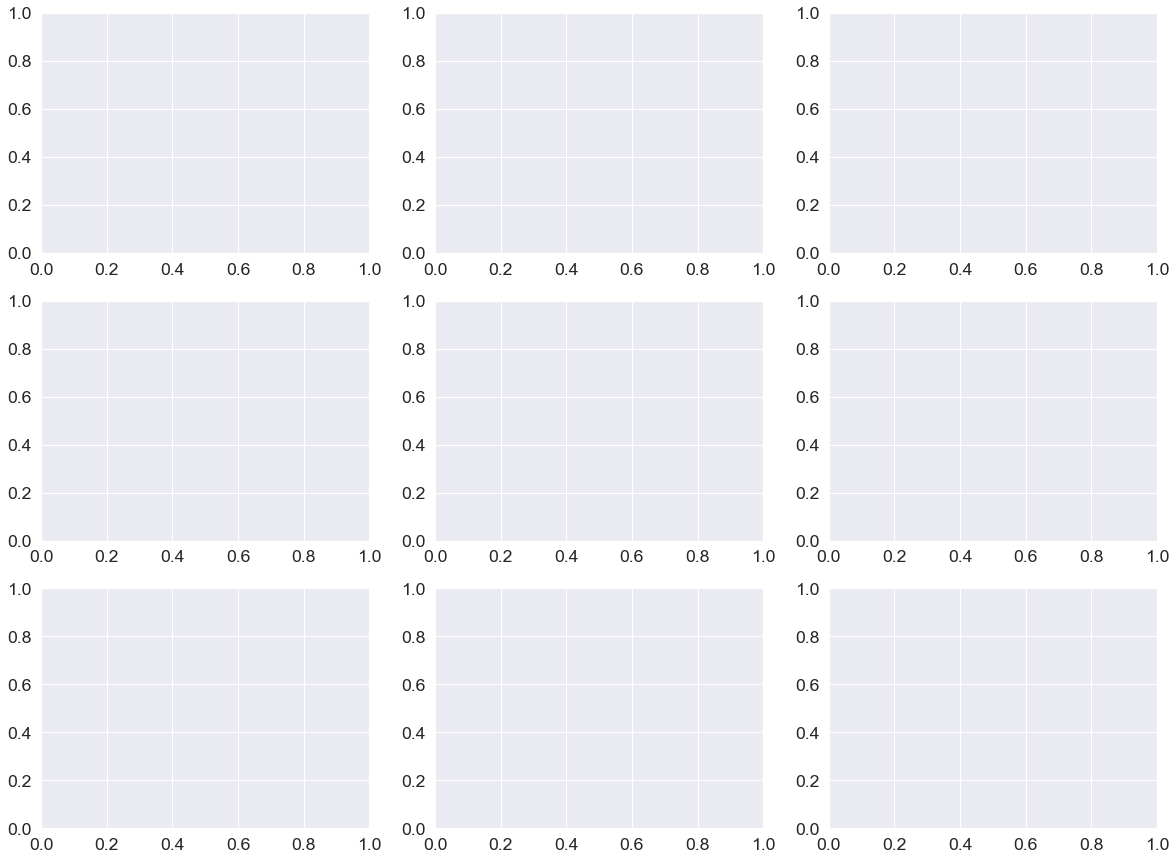

In [28]:
# Plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(3, 3, figsize=(20,15))

In [29]:
# Compute and rank consine similarities
lda_index = similarities.MatrixSimilarity(lda_model[bow], num_features=len(dct))

In [30]:
# Returns most similar songs to a given song
def get_similar_songs(song_bow, top_n=5, first_m_words=300):
    similar_songs = lda_index[lda_model[song_bow]]
    top_n_docs = sorted(enumerate(similar_songs), key=lambda item: -item[1])[1:top_n+1]
  
    # Returns (song id, similarity score, first_m_words of song)
    return list(map(lambda entry: (entry[0], entry[1], clean_data[entry[0]][:first_m_words]), top_n_docs))


In [31]:
# Example
print(data[6864][:300],'\n')
get_similar_songs(bow[6864])

[Verse:]  
She's just a girl and she's on fire  
Hotter than a fantasy, lonely like a highway  
She's living in a world and it's on fire  
Filled with catastrophe, but she knows she can fly away  
  
Ohhhh oh oh oh oh  
She got both feet on the ground  
And she's burning it down  
Ohhhh oh  



[(32754,
  0.9934089,
  "It's night, again  Time for my mind to go wandering  Off on a journey, through space and time  In search of a face I can never find  So I close my eyes and look inside    I can't forget  The night that I saw her we never met  She felt so close to me as I reached for her hand  She drifted away like t"),
 (3521,
  0.9896215,
  "I see a bad moon rising.  I see trouble on the way.  I see earthquakes and lightnin'.  I see bad times today.    Don't go around tonight,  Well it's bound to take your life,  There's a bad moon on the rise.    I hear hurricanes a blowing.  I know the end is coming soon.  I fear rivers over flowing. "),
 (652,
  0.9893638,
  "The waves come in  Crash on the shoreline  Salty water, don't you know  It's yours, yours and mine  So grab your girl  And don't go wastin' time  And let's go down to the water tonight    White capped clouds  Dance in the sunlight  Purple fishes watch  And show you some of their delight  The weather"),
 (39328,
  0.985

In [32]:
# Pass new song through pipeline
new_song = "Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more"
new_tokens = list(map(custom_tokenizer, [nlp(new_song)]))[0]
new_bow = dct.doc2bow(new_tokens)

print(new_song,'\n')
get_similar_songs(new_bow)

Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more 



[(40978,
  0.9896885,
  "Shed my skin since you came in,  Where do you end and I begin?  Awoke my senses yet you stopped time,  You took me to a deeper high,  The essence of my hopes and fears,  Creation of my muddled dreams    Cowboy Style,  With a peaceful smile,  You are from the temple  Won't you stay a while    Found m"),
 (12645,
  0.9892564,
  "Three days of spirits  Tell me now  I'm here like a spell  That's bearing me to drive    Tell me now  That there are three days in a week  Tell me now  To make it so  Make it so I can't speak  Make it so I can't speak  Well I'm here like a spell  That's bearing me to drive    Eyes of blue  Sea of re"),
 (54209,
  0.9892093,
  "I'm a rebel, soul rebel  I'm a capturer, soul adventurer  See the morning sun, on the hillside  Not living good, yeah  You better travel wide  You better travel wide  Said I'm a living man  I've got work to do  If you're not happy, children  Then you must be blue  I said, you must be blue  I'm a reb"),
 (6174,
  0.9